In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf


In [9]:
# Load and Preprocess the Data
data_path = '/content/Time_series_analysis_and_forecast_DATASET.csv'  # Adjust the path if necessary
df = pd.read_csv(data_path)


In [11]:
# Convert the date column to datetime format
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.set_index('FullDate', inplace=True)
df_daily = df.resample('D').sum()

In [12]:
df_daily.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


In [13]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2010-09-01 to 2021-02-28
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       3834 non-null   float64
 1   SysLoad    3834 non-null   float64
 2   GasPrice   3834 non-null   float64
 3   ElecPrice  3834 non-null   float64
dtypes: float64(4)
memory usage: 149.8 KB


In [14]:
df_daily.isnull().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

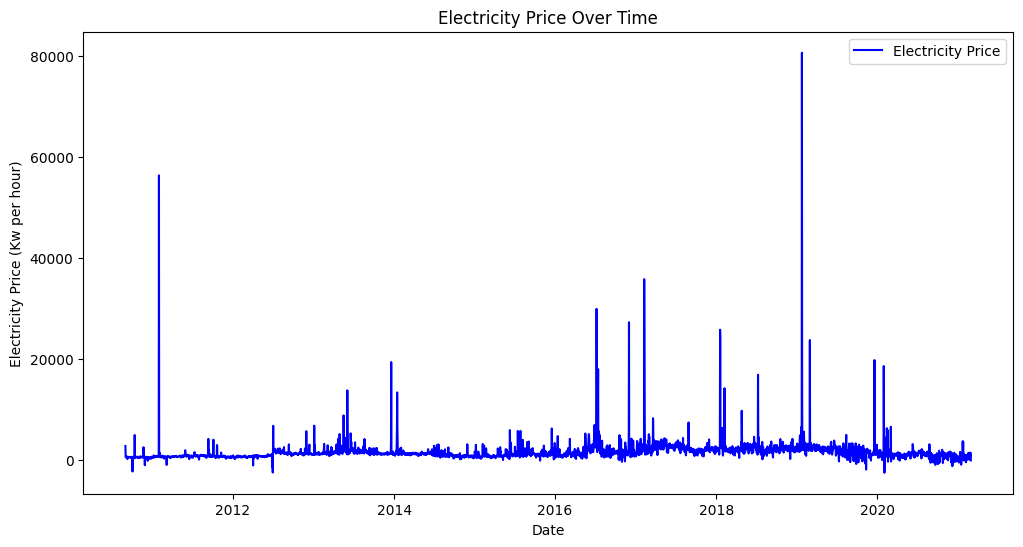

In [15]:
# Exploratory Data Analysis (EDA)
# Plot the electricity price data over time
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['ElecPrice'], label='Electricity Price', color='b')
plt.xlabel('Date')
plt.ylabel('Electricity Price (Kw per hour)')
plt.title('Electricity Price Over Time')
plt.legend()
plt.show()

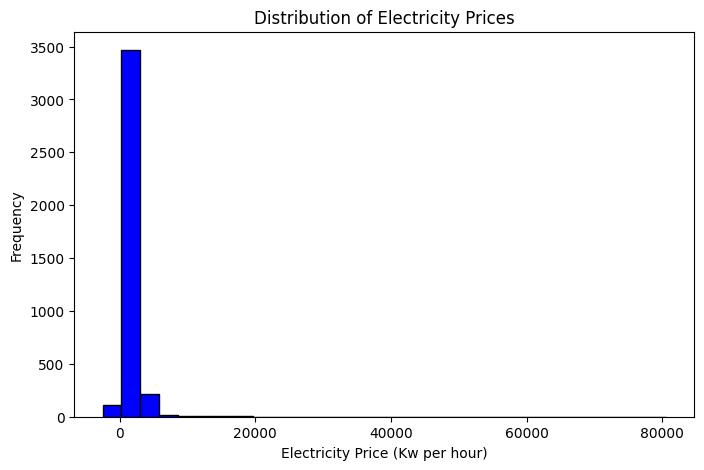

In [16]:
# Plot the distribution of electricity prices
plt.figure(figsize=(8, 5))
plt.hist(df_daily['ElecPrice'], bins=30, color='b', edgecolor='black')
plt.xlabel('Electricity Price (Kw per hour)')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Prices')
plt.show()

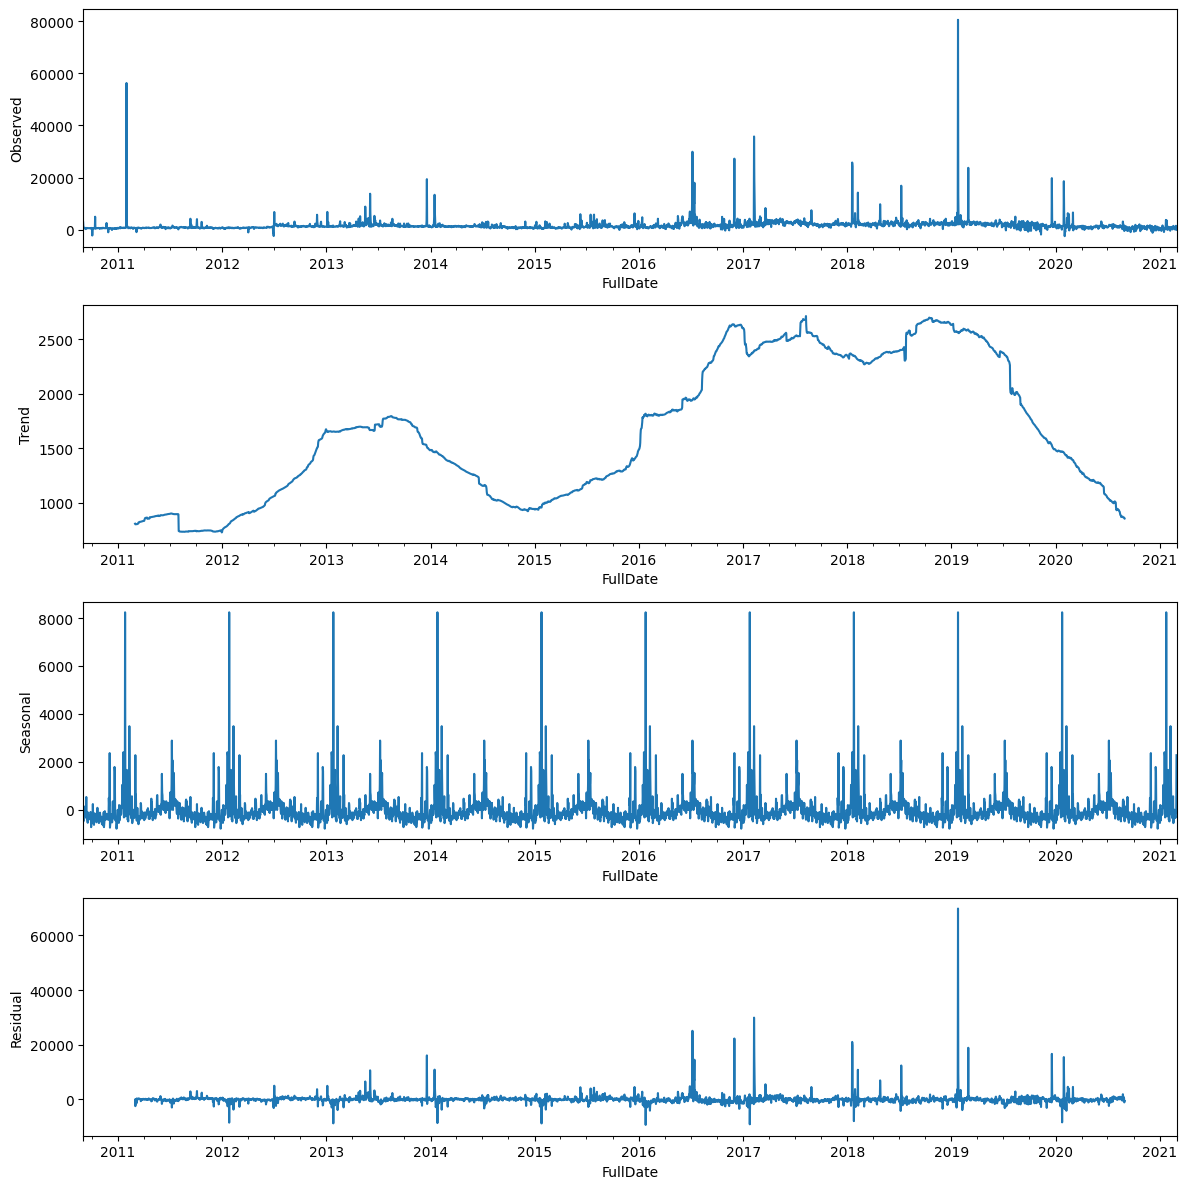

In [17]:
# Statistical Analysis
result = seasonal_decompose(df_daily['ElecPrice'], model='additive', period=365)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

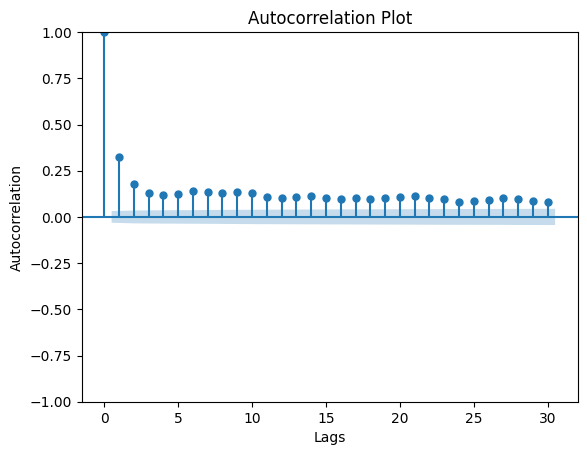

In [18]:
plt.figure(figsize=(8, 5))
plot_acf(df_daily['ElecPrice'], lags=30, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

In [19]:
train_days = 2757
train = df_daily[:train_days]
test = df_daily[train_days:]

In [21]:
#  Hyperparameter Tuning
train_prophet = train.reset_index().rename(columns={'FullDate': 'ds', 'ElecPrice': 'y'})

mse_scores = []
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10, 100]
}

In [22]:
for params in ParameterGrid(param_grid):
    model = Prophet(**params)
    model.fit(train_prophet)
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    mse = mean_squared_error(test['ElecPrice'], forecast.loc[train_days:, 'yhat'])
    mse_scores.append((params, mse))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/y1it978j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/2qryl0tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35614', 'data', 'file=/tmp/tmp5rfkaglk/y1it978j.json', 'init=/tmp/tmp5rfkaglk/2qryl0tx.json', 'output', 'file=/tmp/tmp5rfkaglk/prophet_modelc6j8hk6x/prophet_model-20230801064912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5r

In [23]:
best_params, best_mse = min(mse_scores, key=lambda x: x[1])
print("Best Hyperparameters:", best_params)
print("Best RMSE:", sqrt(best_mse))

Best Hyperparameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}
Best RMSE: 3025.3361428577914


In [24]:
# Model Development using Prophet with Best Hyperparameters
best_model = Prophet(**best_params)
best_model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/074we3hk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/5c1anjk9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1763', 'data', 'file=/tmp/tmp5rfkaglk/074we3hk.json', 'init=/tmp/tmp5rfkaglk/5c1anjk9.json', 'output', 'file=/tmp/tmp5rfkaglk/prophet_modelw1oz_6gh/prophet_model-20230801065103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:51:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
# Model Evaluation using RMSE
forecast_test = best_model.predict(test.reset_index().rename(columns={'FullDate': 'ds'}))
rmse_test = sqrt(mean_squared_error(test['ElecPrice'], forecast_test['yhat']))
print("Test RMSE:", rmse_test)

Test RMSE: 3025.3361428577914


In [26]:
# Visualization of Model RMSE
mse_values = [mse for _, mse in mse_scores]
changepoint_prior_scales = [params['changepoint_prior_scale'] for params, _ in mse_scores]
seasonality_prior_scales = [params['seasonality_prior_scale'] for params, _ in mse_scores]


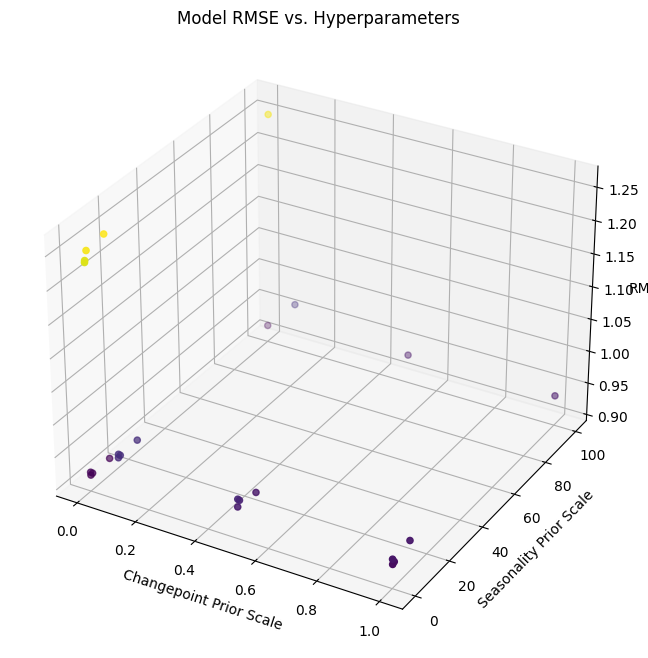

In [27]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(changepoint_prior_scales, seasonality_prior_scales, mse_values, c=mse_values, cmap='viridis')
ax.set_xlabel('Changepoint Prior Scale')
ax.set_ylabel('Seasonality Prior Scale')
ax.set_zlabel('RMSE')
plt.title('Model RMSE vs. Hyperparameters')
plt.show()

In [30]:
mse_values = np.array(mse_values).reshape(len(param_grid['changepoint_prior_scale']), len(param_grid['seasonality_prior_scale']))
changepoint_prior_scales = np.array(param_grid['changepoint_prior_scale'])
seasonality_prior_scales = np.array(param_grid['seasonality_prior_scale'])

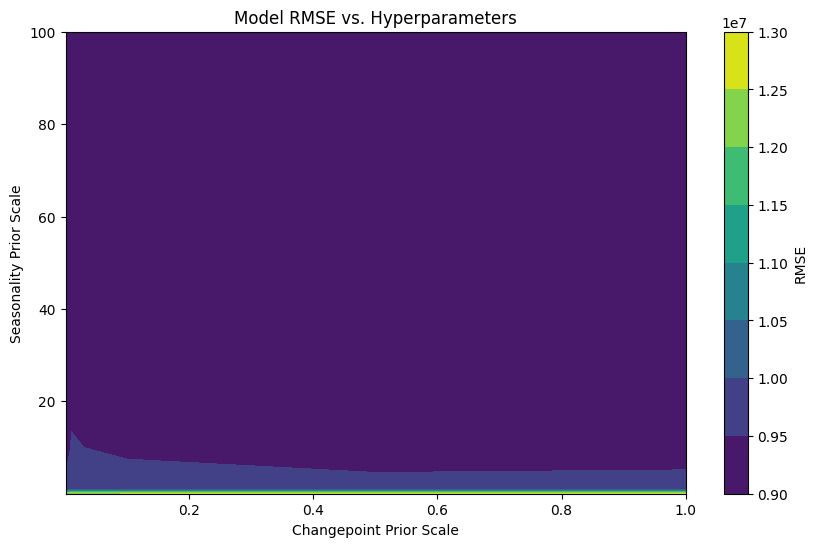

In [31]:
plt.figure(figsize=(10, 6))
cs = plt.contourf(changepoint_prior_scales, seasonality_prior_scales, mse_values, cmap='viridis')
plt.colorbar(cs, label='RMSE')
plt.xlabel('Changepoint Prior Scale')
plt.ylabel('Seasonality Prior Scale')
plt.title('Model RMSE vs. Hyperparameters')
plt.show()

In [32]:
# Forecasting Future Prices
future_forecast = best_model.make_future_dataframe(periods=365)  # Forecast for the next year
forecast = best_model.predict(future_forecast)


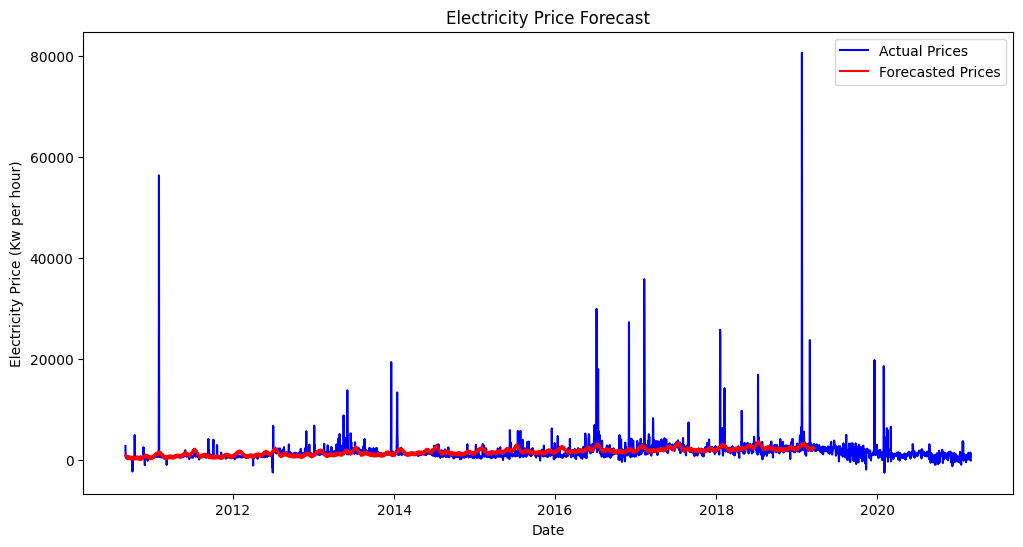

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['ElecPrice'], label='Actual Prices', color='b')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Prices', color='r')
plt.xlabel('Date')
plt.ylabel('Electricity Price (Kw per hour)')
plt.title('Electricity Price Forecast')
plt.legend()
plt.show()

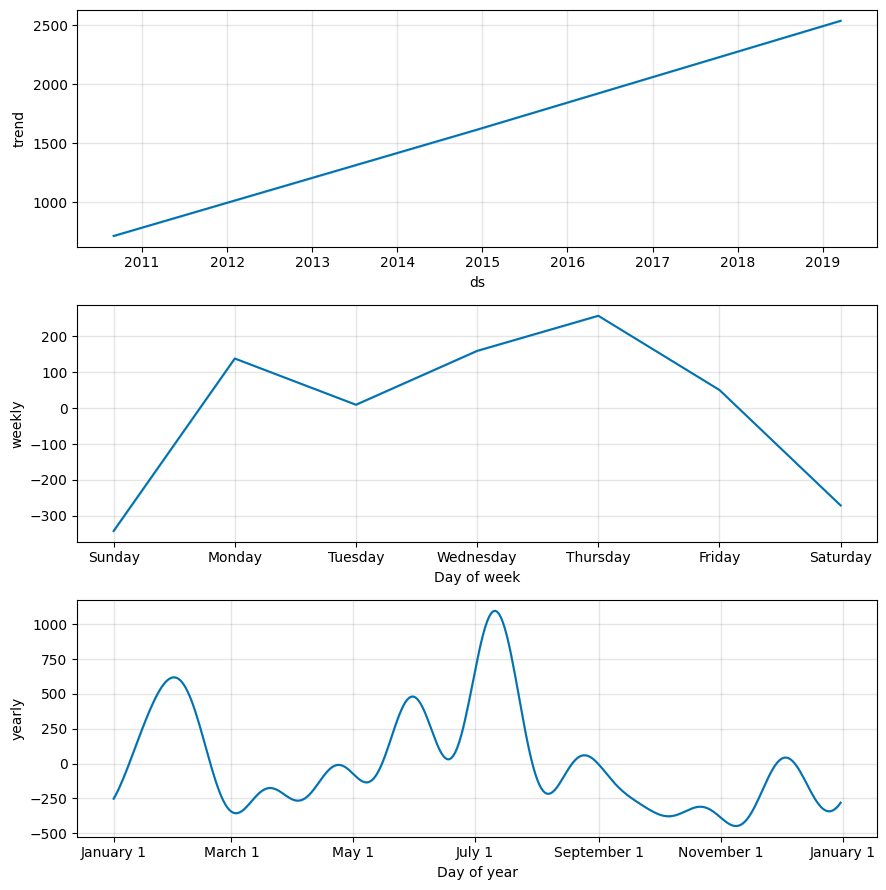

In [34]:
best_model.plot_components(forecast)
plt.show()

In [35]:
df_daily = df.resample('D').sum()

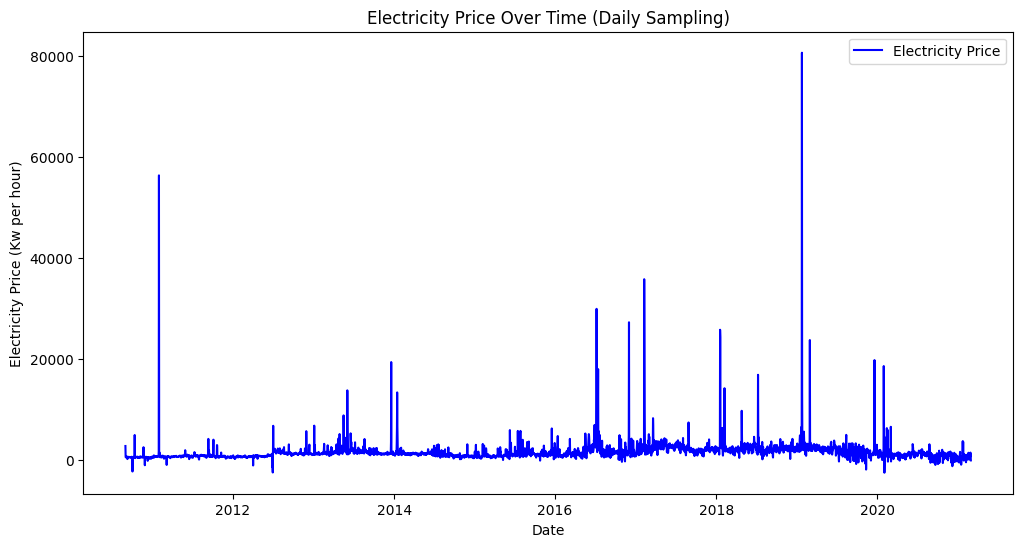

In [36]:
# Plot the ElecPrice over time
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['ElecPrice'], label='Electricity Price', color='b')
plt.xlabel('Date')
plt.ylabel('Electricity Price (Kw per hour)')
plt.title('Electricity Price Over Time (Daily Sampling)')
plt.legend()
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller

# Resample the data from hourly to daily and sum over the hours for each day
df_daily = df.resample('D').sum()

# Perform ADF test on 'SysLoad'
result_sysload = adfuller(df_daily['SysLoad'])
p_value_sysload = round(result_sysload[1], 6)

# Perform ADF test on 'GasPrice'
result_gasprice = adfuller(df_daily['GasPrice'])
p_value_gasprice = round(result_gasprice[1], 6)

print("P-value of SysLoad:", p_value_sysload)
print("P-value of GasPrice:", p_value_gasprice)

P-value of SysLoad: 0.004254
P-value of GasPrice: 0.045027


In [38]:
from statsmodels.tsa.stattools import adfuller

# Resample the data from hourly to daily and sum over the hours for each day
df_daily = df.resample('D').sum()

# Perform ADF test on 'GasPrice'
result_gasprice = adfuller(df_daily['GasPrice'])
critical_values_gasprice = {key: round(value, 4) for key, value in result_gasprice[4].items()}

# Perform ADF test on 'ElecPrice'
result_elecprice = adfuller(df_daily['ElecPrice'])
critical_values_elecprice = {key: round(value, 4) for key, value in result_elecprice[4].items()}

print("GasPrice - Critical Values:")
print(critical_values_gasprice)

print("\nElecPrice - Critical Values:")
print(critical_values_elecprice)


GasPrice - Critical Values:
{'1%': -3.4321, '5%': -2.8623, '10%': -2.5672}

ElecPrice - Critical Values:
{'1%': -3.4321, '5%': -2.8623, '10%': -2.5672}


In [39]:
# Model Development using Prophet with Best Hyperparameters
best_model = Prophet(**best_params)
best_model.fit(train_prophet)

# Model Evaluation using RMSE
forecast_test = best_model.predict(test.reset_index().rename(columns={'FullDate': 'ds'}))
rmse_test = sqrt(mean_squared_error(test['ElecPrice'], forecast_test['yhat']))
print("Test RMSE:", rmse_test)

# Step 9: Function to Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Calculate MAPE
mape_test = calculate_mape(test['ElecPrice'], forecast_test['yhat'])
mape_test = round(mape_test, 2)
print("Test MAPE:", mape_test, "%")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/pn6g9r8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/z1fwh5my.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39732', 'data', 'file=/tmp/tmp5rfkaglk/pn6g9r8c.json', 'init=/tmp/tmp5rfkaglk/z1fwh5my.json', 'output', 'file=/tmp/tmp5rfkaglk/prophet_model12dijz0m/prophet_model-20230801071013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:10:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:10:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test RMSE: 3025.3361428577914
Test MAPE: nan %


<ipython-input-39-662f8209ab29>:12: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((actual - predicted) / actual)) * 100


In [40]:
# Model Evaluation using RMSE
forecast_test = best_model.predict(test.reset_index().rename(columns={'FullDate': 'ds'}))
rmse_test = sqrt(mean_squared_error(test['ElecPrice'], forecast_test['yhat']))
print("Test RMSE:", rmse_test)

# Function to Calculate MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Calculate MAPE
mape_test = calculate_mape(test['ElecPrice'], forecast_test['yhat'])
mape_test = round(mape_test, 2)
print("Test MAPE:", mape_test, "%")

Test RMSE: 3025.3361428577914
Test MAPE: nan %


<ipython-input-40-02cb544bcb55>:8: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((actual - predicted) / actual)) * 100


Month with the Highest Yearly Seasonality: 2871


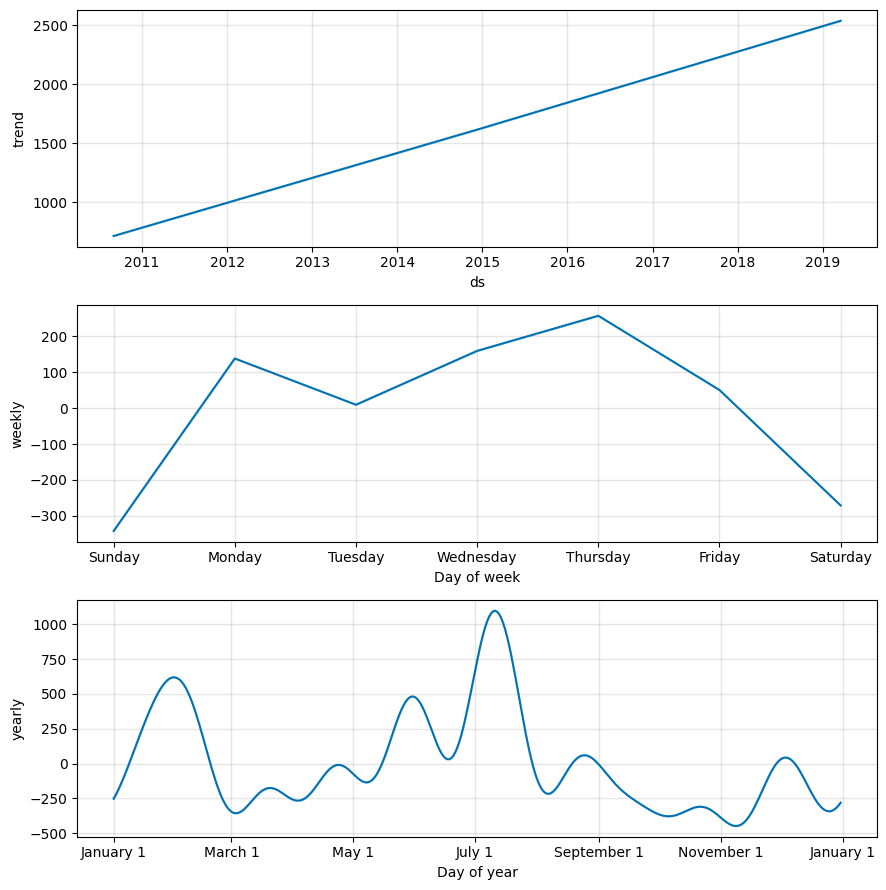

In [42]:
# Forecasting Future Prices
future_forecast = best_model.make_future_dataframe(periods=365)  # Forecast for the next year
forecast = best_model.predict(future_forecast)

# Identifying the Month with Highest Yearly Seasonality
# Get the forecasted components
components = best_model.plot_components(forecast)

# Extract the yearly seasonality data
yearly_seasonality = forecast['yearly'].values

# Identify the month with the highest yearly seasonality
highest_month = np.argmax(yearly_seasonality) + 1

print("Month with the Highest Yearly Seasonality:", highest_month)

In [43]:
# Model Evaluation using MAPE
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Calculate MAPE
mape_test = calculate_mape(test['ElecPrice'], forecast_test['yhat'])
mape_test = round(mape_test, 2)
print("Test MAPE:", mape_test, "%")

Test MAPE: nan %


<ipython-input-43-24f63c2b586e>:3: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((actual - predicted) / actual)) * 100


In [44]:
# Model Evaluation using RMSE
forecast_test = best_model.predict(test.reset_index().rename(columns={'FullDate': 'ds'}))
rmse_test = sqrt(mean_squared_error(test['ElecPrice'], forecast_test['yhat']))
rmse_test = round(rmse_test, 2)
print("Test RMSE:", rmse_test)

Test RMSE: 3025.34


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [48]:
# Prepare the Multivariate Training Data
train_prophet_multivariate = train.copy()
train_prophet_multivariate['SysLoad'] = df_daily.loc[train_prophet_multivariate.index, 'SysLoad'].values
train_prophet_multivariate['Tmax'] = df_daily.loc[train_prophet_multivariate.index, 'Tmax'].values
train_prophet_multivariate['GasPrice'] = df_daily.loc[train_prophet_multivariate.index, 'GasPrice'].values

In [50]:
# Prepare the Multivariate Training Data
train_prophet_multivariate = pd.DataFrame()
train_prophet_multivariate['ds'] = train.index
train_prophet_multivariate['y'] = train['ElecPrice'].values
train_prophet_multivariate['SysLoad'] = df_daily.loc[train.index, 'SysLoad'].values
train_prophet_multivariate['Tmax'] = df_daily.loc[train.index, 'Tmax'].values
train_prophet_multivariate['GasPrice'] = df_daily.loc[train.index, 'GasPrice'].values


In [51]:
# Model Development using Prophet with Best Hyperparameters (Multivariate)
best_model_multivariate = Prophet(**best_params)
best_model_multivariate.add_regressor('SysLoad')
best_model_multivariate.add_regressor('Tmax')
best_model_multivariate.add_regressor('GasPrice')
best_model_multivariate.fit(train_prophet_multivariate)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/_6dy4y43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/rl13xxe1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77590', 'data', 'file=/tmp/tmp5rfkaglk/_6dy4y43.json', 'init=/tmp/tmp5rfkaglk/rl13xxe1.json', 'output', 'file=/tmp/tmp5rfkaglk/prophet_model0baun0n_/prophet_model-20230801072028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [53]:
# Forecasting Future Prices (Multivariate)
future_forecast_multivariate = best_model_multivariate.make_future_dataframe(periods=365)  # Forecast for the next year

# Only keep the dates that are available in df_daily
future_forecast_multivariate = future_forecast_multivariate[future_forecast_multivariate['ds'].isin(df_daily.index)]

# Get the corresponding 'SysLoad', 'Tmax', and 'GasPrice' values from df_daily
future_forecast_multivariate['SysLoad'] = df_daily.loc[future_forecast_multivariate['ds'], 'SysLoad'].values
future_forecast_multivariate['Tmax'] = df_daily.loc[future_forecast_multivariate['ds'], 'Tmax'].values
future_forecast_multivariate['GasPrice'] = df_daily.loc[future_forecast_multivariate['ds'], 'GasPrice'].values

forecast_multivariate = best_model_multivariate.predict(future_forecast_multivariate)

In [55]:
# Step 4: Prepare the Multivariate Training Data (Exclude 'Tmax')
train_prophet_multivariate = pd.DataFrame()
train_prophet_multivariate['ds'] = train.index
train_prophet_multivariate['y'] = train['ElecPrice'].values
train_prophet_multivariate['SysLoad'] = df_daily.loc[train.index, 'SysLoad'].values
train_prophet_multivariate['GasPrice'] = df_daily.loc[train.index, 'GasPrice'].values

# Step 5: Model Development using Prophet with Best Hyperparameters (Multivariate, excluding 'Tmax')
best_model_multivariate_no_tmax = Prophet(**best_params)
best_model_multivariate_no_tmax.add_regressor('SysLoad')
best_model_multivariate_no_tmax.add_regressor('GasPrice')
best_model_multivariate_no_tmax.fit(train_prophet_multivariate)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/twcqj9tl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5rfkaglk/z7f9birz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74862', 'data', 'file=/tmp/tmp5rfkaglk/twcqj9tl.json', 'init=/tmp/tmp5rfkaglk/z7f9birz.json', 'output', 'file=/tmp/tmp5rfkaglk/prophet_modelej237zbn/prophet_model-20230801072420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:24:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
